In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_order, converge_ZNE_loocv

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from samplers_util import thermal_rejection
from functions_util import calibrate_sim_Omegas


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Data generated by Jij_Extrapolation.ipynb
file = np.load('plotting_data_fig_4.npz')
#np.savez('Plotting data', times = times, leakage_matrix = leakage_matrix, flopping_matrix = flopping_matrix, flopping_std_matrix = flopping_std_matrix, flopping_matrix_ps = flopping_matrix_ps, flopping_matrix_smooth = flopping_matrix_smooth, flopping_std_matrix_smooth = flopping_std_matrix_smooth, ZNE_data = ZNE_data, ZNE_data_smooth = ZNE_data_smooth, Omega = Omega, decoherence_limit = decoherence_limit)
times = file['times']
theta_list = file['theta_list']
flopping_ps_smoothed = file['flopping_ps_smoothed']
flopping_std_matrix = file['flopping_std_matrix']
shots = file['shots']
Omega = file['Omega']
flopping_matrix_smooth = file['flopping_matrix_smooth']
flopping_matrix = file['flopping_matrix']
leakage_matrix = file['leakage_matrix']
#import all data:

theta_sub_index = [0, 1, 2, 3, 4]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
#Make font size 16

ZNE_function = converge_ZNE_loocv
ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, y_error=weights)

#Get ZNed Data:
ZNE_data_ps = np.zeros(len(times))
ZNE_data_raw = np.zeros(len(times))
ZNE_funcs = []
ZNE_funcs_ps = []
for i in range(30):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_ps_smoothed[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_funcs_ps.append(fit_func)
    ZNE_data_ps[i] = fit_func(0)
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_smooth[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_funcs.append(fit_func)
    ZNE_data_raw[i] = fit_func(0)

ZNE_data_smooth_ps = savgol_filter(ZNE_data_ps, 6, 2)
ZNE_data_smooth = savgol_filter(ZNE_data_raw, 6, 2)

dense_theta = np.linspace(0, theta_list[theta_sub_index[-1]]+0.02, 25)


[nan, 0.00047944996341438935, 0.0004992739667443999, 0.001017954079882485]
1
[nan, 0.0032398118630739626, 0.0035644773104865713, 0.004534395231014102]
1
[nan, 0.008614101014338902, 0.004639103612967784, 0.014331847801239153]
2
[nan, 0.011418140591733957, 0.006196468908015523, 0.0144694389695861]
2
[nan, 0.009374247456515538, 0.009147340318547586, 0.019878333997214018]
2
[nan, 0.005463683390408974, 0.005428179093048944, 0.013706154928144025]
2
[nan, 0.0138458388800976, 0.014572412837077667, 0.01933600991768773]
1
[nan, 0.007955754254724766, 0.007814489470711592, 0.011550647505606925]
2
[nan, 0.018811651506554977, 0.007853644624001564, 0.014393316972457798]
2
[nan, 0.015128660429562159, 0.005179977015501165, 0.011671784498694418]
2
[nan, 0.027030676536880148, 0.00031068237907315444, 0.0003820013161542701]
2
[nan, 0.014666730721745598, 0.001424285713185198, 0.0021094920323035914]
2
[nan, 0.03515172085464457, 0.008446965863030788, 0.0027189972254210324]
3
[nan, 0.02742130355288132, 0.01028

[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
0.161585610648723
[0.05005183 0.21442118]
[ 0.14390801 -0.25101571  0.07694556]


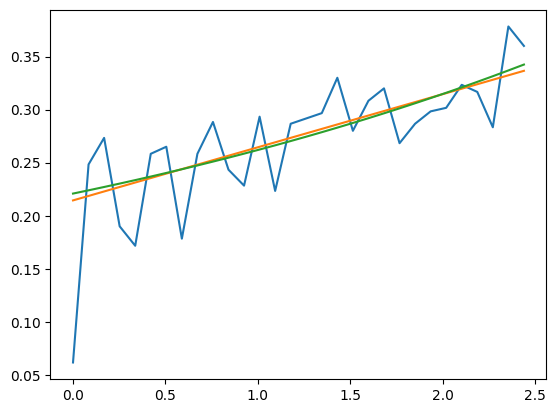

In [19]:
#Generate dense theta simulation data:  from detune scanning




#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
#Need to set Jij ~1000*2*pi, so Omega = np.sqrt(1000). This way the time scale is ms for a full Jij oscillation
#Realistic:
#theta_0  = 0.060577043438396795
#theta_dot = 0.0502438865537055 * 1e3
#print(theta_0)
#print(theta_dot)
#Not realistic:
theta_0  = 0.10858132704355991
#theta_0 = 0
theta_dot = 0.02172438865537055 * 1e3

print(times)
theta_f = theta_0 + theta_dot*max(times)/1e3
print(theta_f)

#theta_0 = 0
#theta_dot = 0
sx, sy, sz = get_s_lists(2)

#t_list = np.linspace(0, max(times), 200)# * 1e-3
t_list = times
psi0 = tensor(basis(2,0), basis(2,1))


def J_func(J,i,j):
    return J*np.exp(-1*abs(i-j)+1)

def genH(theta_0, J, B):
    delta = thermal_rejection(theta_0,1)[0]
    factor = (1 - delta)**2
    #HXX = sx[0]*0
    #for i in range(2):
    #    for j in range(i+1,2):
    #        HXX += J_func(J,i,j)*factor*(sx[i]*sx[j])
    HXX = J*sx[0]*sx[1]*factor
    
    #HXX = sum([ sum( [J(i,j)*factor*(sx[i]*sx[j]) of i in range(j+1,4)] for j in range(4)]))

    #HXX = J*factor*(sx[0]*sx[1]) 
    #print(HXX)
    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    #print(HB)

    return [HXX + HB]


#psi0 = tensor(basis(2,0), basis(2,0))
#yplus = (basis(2,0) + 1j*basis(2,1)).unit()
#minus = 
#psi0 = tensor(yplus, yplus)

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(J,B, obs = None, noise={}, time = t_list):
    xrate = 0
    zrate = 0
    theta_0 = 0
    try:
        xrate = noise['x']
    except:
        pass
    try:
        zrate = noise['z']
    except:
        pass
    try:
        theta_0 = noise['theta']
    except:
        pass
    #print(xrate)
    #print(zrate)
    #print(theta_0)
    H = genH(theta_0,J,B)
    noisy_ops = [sx[i]*xrate for i in range(2)]
    noisy_ops = [sx[0]*xrate]
    #Sz_noise = (sz[0] * sz[1])*zrate#*sx[2]*sz[3])*zrate
    Sz_noise = [sz[i]*zrate for i in range(2)]
    #noisy_ops = []
    noisy_ops.append(Sz_noise)
    
    results = mesolve(H, psi0,time, noisy_ops, obs, options=options)#, ntraj=1)
    return results
sim_shots = 500
#


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(J,B, obs=None, noise={}, time=t_list):
    #H = genH(theta_0, theta_dot)
    #run(theta_0, J,B)
    #print(noise)
    #full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, J,B,obs = obs, noise=noise, time=time) for _ in range(shots))
    full_results = np.array([run(J,B,obs = obs, noise=noise, time=time) for _ in range(sim_shots)])
    
    averaged = np.zeros(len(time))
    for item in full_results:
        #print(item.expect[0])
        averaged += sum(item.expect)
    averaged = averaged/sim_shots
    return averaged#[indices]
#fit leakage matrix to a line:
def linear(x, m, c):
    return m*x + c
popt, pcov = curve_fit(linear, times[1:], leakage_matrix[1:,0])
print(popt)
intercept = 1-popt[1]
slope = popt[0]
plt.plot(times, leakage_matrix[:,0])
plt.plot(times, linear(times, *popt))

def exp_fit(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(exp_fit, times[1:], leakage_matrix[1:,0], p0=[1, .05, -1])
print(popt)
#plt.plot(times, leakage_matrix[:,0])
plt.plot(times, exp_fit(times, *popt))


In [20]:
J = 1.05*np.pi#*0.95/2
B = 0#0.4*J
leakage_obs = [sz[0]*sz[1]]#
oscillation_obs = [sz[0], -1*sz[1]]
#print(np.sqrt(0.0015)*J)
noise_dict = {'x':np.abs(popt[1])/np.sqrt(2), 'z':0, 'theta':theta_0}

results_Jij_oscillation = gen_full_results(J, B, obs=oscillation_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
results_Jij_leakage = gen_full_results( J, B, obs=leakage_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#Check if dense_theta_oscillations is defined. If not, define it

Omega_comps = calibrate_sim_Omegas(dense_theta, np.sqrt(J), times, debug=False)*np.sqrt(J)
J_calibrated = Omega_comps**2

try:
    dense_theta_oscillations
except:
    dense_theta_oscillations = []
    for theta_index in range(len(dense_theta)):
        theta = dense_theta[theta_index]
        J_calibrated = Omega_comps[theta_index]**2
        
    #for theta_point in dense_theta:
        noise_dict['theta'] = theta#{'x':np.sqrt(slope), 'z':0, 'theta':theta_point}
        dense_theta_oscillations.append(gen_full_results(J_calibrated, B, obs=oscillation_obs, noise=noise_dict))
        

/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [21]:
#Plotting the ZNE Data slice:
#Add a vertial slice at the 3rd peak:
index = 12
dense_theta_oscillations_array = np.array(dense_theta_oscillations)

dense_flopping = ZNE_funcs_ps[index](dense_theta)
dense_ZNE_no_ps = ZNE_funcs[index](dense_theta)


In [22]:
errors_basic = np.abs((np.cos(Omega[0]*times) - flopping_matrix[:,0])/np.cos(Omega[0]*times))
errors_ZNE = np.abs((np.cos(Omega[0]*times) - ZNE_data_smooth)/np.cos(Omega[0]*times))
errors_PS_ZNE = np.abs((np.cos(Omega[0]*times) - ZNE_data_smooth_ps)/np.cos(Omega[0]*times))
errors_PS_only = np.abs((np.cos(Omega[0]*times) - flopping_ps_smoothed[:,0])/np.cos(Omega[0]*times))
#Smooth all the errors by convolving with a gaussian:
window = 10



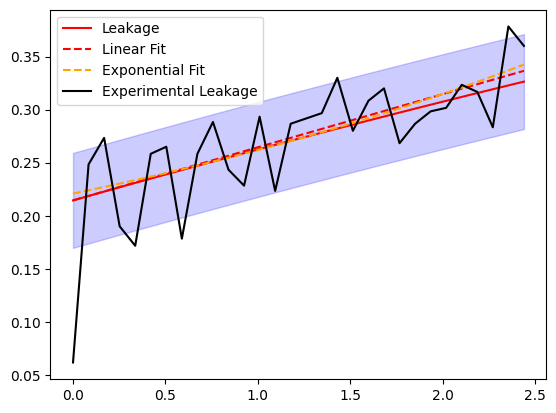

In [23]:
#plot the leakage of the simulation and the experimental data
plt.plot(times, 1+results_Jij_leakage*intercept, label = 'Leakage', color = 'r')
#Generate a bist fit line of the leakage matrix, not including the t=0 point:
#cureve fit:
#popt, pcov = curve_fit(linear, times[1:], leakage_matrix[1:,0])
#print(popt)
plt.plot(times, linear(times, slope, -1*intercept+1), color = 'r', linestyle = '--', label="Linear Fit")

plt.plot(times, exp_fit(times, *popt), color = 'orange', linestyle = '--', label="Exponential Fit")

plt.fill_between(times, 1+results_Jij_leakage*intercept-1/np.sqrt(500), 1+results_Jij_leakage*intercept+1/np.sqrt(500), color = 'blue', alpha = 0.2)
plt.plot(times, leakage_matrix[:,0], label = 'Experimental Leakage', color = 'k')
plt.legend()

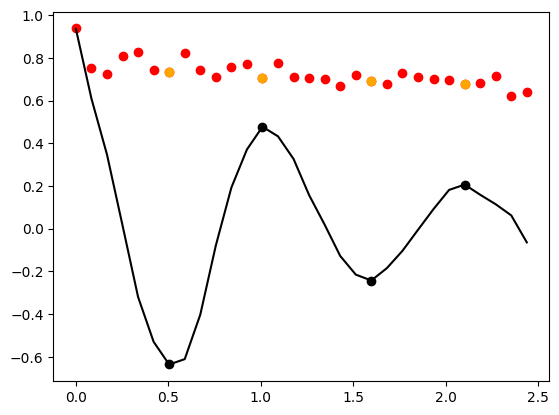

In [24]:
#Get the peak indices:
peak_indices = np.where(np.diff(np.sign(np.diff(np.abs(flopping_matrix_smooth[:,0])))) == -2)[0]+1

plt.plot(times[peak_indices], flopping_matrix_smooth[peak_indices,0], 'o', color = 'k')
plt.plot(times, flopping_matrix_smooth[:,0], label = 'Experimental Flopping', color = 'k')
plt.scatter(times, 1-leakage_matrix[:,0], label = '1-Leakage', color = 'r')
plt.scatter(times[peak_indices], 1-leakage_matrix[peak_indices,0], label = '1-Leakage', color = 'orange')


(30,)
0.78557881772287


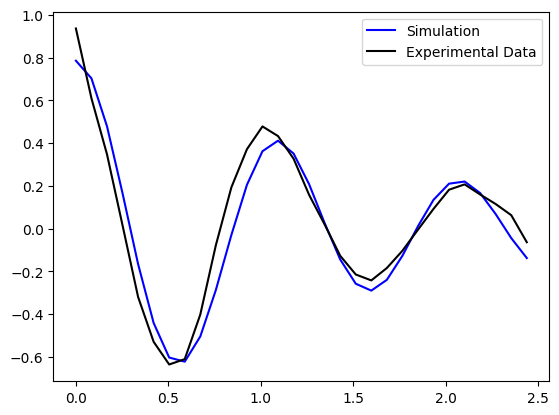

In [25]:
#Plot the oscillations:
print(results_Jij_oscillation.shape)
print(intercept)
plt.plot(times, results_Jij_oscillation*intercept/2, label = 'Simulation', color = 'b')
plt.plot(times, flopping_matrix_smooth[:,0], label = 'Experimental Data', color = 'k')


plt.legend()

In [26]:
#TODO: Zero Noise Limit Extrapolation